# Set up

In [1]:
import os
import numpy as np
import tensorflow as tf
import dataHandler
import csv
import numpy as np
import csv
import dataHandler
import itertools
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from urllib.request import urlretrieve
from os.path import isfile, isdir
from tensorflow_vgg import vgg16
from tensorflow_vgg import utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras import backend as K
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

%matplotlib inline

C:\ProgramFiles2\Anaconda3\envs\tensorflow_gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# classes=['Achaemenid', 'Ancient', 'Art deco', 'Baroque', 'Byzantine', 'Chinese', 'Indo-islamic', 'Neoclassical', 'Postmodernism', 'Renesans', 'Romanesque', 'Russian Revival', 'Secession', 'Victorian + Quenn anne']
classes=['Ancient', 'Byzantine', 'Chinese', 'Postmodernism', 'Russian Revival', 'Victorian + Quenn anne']
batch_size = 100
main_path='c:\\Users\\Tomasz Marcinkowski\\Documents\\MEGA\\Zbiory\\Zbior4_final_tr2\\'
data_dir_train = os.path.join(main_path, 'Train\\')
data_dir_test = os.path.join(main_path, 'Test\\')
data_dir_valid = os.path.join(main_path, 'Valid\\')

In [3]:
contents = os.listdir(data_dir_train)
# classes = [each for each in contents if os.path.isdir(os.path.join(data_dir_train, each))]
classes

['Ancient',
 'Byzantine',
 'Chinese',
 'Postmodernism',
 'Russian Revival',
 'Victorian + Quenn anne']

In [4]:
def createTransferCodes(data_dir, sufix):
    # Create transfer codes for each image and store in files 'codes, labels'
    batch_size = 10
    codes_list = []
    labels = []
    batch = []

    codes = None

    print('_'*50)
    print('Creating transfer codes:')
    print('_'*50)

    #with tf.Session() as sess:
    with tf.Session() as sess:
        vgg = vgg16.Vgg16()
        input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
        with tf.name_scope("content_vgg"):
            vgg.build(input_)

        for each in classes:
            print("Starting {} images".format(each))
            class_path = data_dir + each
            files = os.listdir(class_path)
            for ii, file in enumerate(files, 1):

                # Add images to the current batch
                img = utils.load_image(os.path.join(class_path, file))
                batch.append(img.reshape((1, 224, 224, 3)))
                labels.append(each)

                # Running the batch through the network to get the codes
                if ii % batch_size == 0 or ii == len(files):

                    # Image batch to pass to VGG network
                    images = np.concatenate(batch)

                    # Get the values from the relu6 layer of the VGG network
                    feed_dict = {input_: images}
                    codes_batch = sess.run(vgg.relu6, feed_dict=feed_dict)

                    # store the codes in an array
                    if codes is None:
                        codes = codes_batch
                    else:
                        codes = np.concatenate((codes, codes_batch))

                    # Reset to start building the next batch
                    batch = []
                    print('{} images processed'.format(ii))

    # -----------------------------------------------------------
    # store codes locally
    with open('codes' + sufix, 'w') as f:
        codes.tofile(f)
        print('Transfer codes saved to file "codes" in project directory')

    # store labels locally
    with open('labels' + sufix, 'w') as f:
        writer = csv.writer(f, delimiter='\n')
        writer.writerow(labels)
        print('labels saved to file "labels" in project directory')

In [ ]:
createTransferCodes(data_dir_train, '_train')

In [ ]:
createTransferCodes(data_dir_test, '_test')

In [ ]:
createTransferCodes(data_dir_valid, '_valid')

In [5]:
# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues):
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=90)
#     plt.yticks(tick_marks, classes)

#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, cm[i, j],
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

# #     plt.tight_layout()
#     plt.ylabel('Prawdziwe klasy')
#     plt.xlabel('Przewidziane klasy')

In [6]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [7]:
EPOCHS = 100
optimizer = Adam(lr=0.01)

In [8]:
def loadLabelsAndCodes(lab_file, codes_file):
    with open(lab_file) as f:
        reader = csv.reader(f, delimiter='\n')
        labels = np.array([each for each in reader]).squeeze()
        labels = labels[:-1]
        print('loaded labels', labels.shape)

    with open(codes_file) as f:
        codes = np.fromfile(f, dtype=np.float32)
        codes = codes.reshape((len(labels), -1))
        print('loaded codes', codes.shape)
    return labels, codes

In [9]:
codes_sub_folder = 'Method4_Codes'

In [10]:
labels_train, codes_train = loadLabelsAndCodes(codes_sub_folder + '/labels_train', codes_sub_folder + '/codes_train')

loaded labels (4418,)
loaded codes (4418, 4096)


In [11]:
labels_test, codes_test = loadLabelsAndCodes(codes_sub_folder + '/labels_test', codes_sub_folder + '/codes_test')

loaded labels (915,)
loaded codes (915, 4096)


In [12]:
labels_valid, codes_valid = loadLabelsAndCodes(codes_sub_folder + '/labels_valid', codes_sub_folder + '/codes_valid')

loaded labels (777,)
loaded codes (777, 4096)


In [13]:
def encode(labels, codes):
    labels, classes = dataHandler.one_hot_encode(labels)
    X_train, X_test, y_train, y_test = train_test_split(codes, labels, test_size=0.0, random_state=42)
    X_train = X_train.astype('float32')
    print('X shape', X_train.shape)
    print('y shape', y_train.shape)
    return X_train, y_train

In [14]:
X_train, y_train = encode(labels_train, codes_train)

labels ['Ancient', 'Byzantine', 'Chinese', 'Postmodernism', 'Russian Revival', 'Victorian + Quenn anne']
X shape (4418, 4096)
y shape (4418, 6)


In [15]:
X_test, y_test = encode(labels_test, codes_test)

labels ['Ancient', 'Byzantine', 'Chinese', 'Postmodernism', 'Russian Revival', 'Victorian + Quenn anne']
X shape (915, 4096)
y shape (915, 6)


In [16]:
X_valid, y_valid = encode(labels_valid, codes_valid)

labels ['Ancient', 'Byzantine', 'Chinese', 'Postmodernism', 'Russian Revival', 'Victorian + Quenn anne']
X shape (777, 4096)
y shape (777, 6)


In [17]:
# --------------------------------------------------------------
lr_scheduler = LearningRateScheduler(dataHandler.scheduler)
K.set_image_dim_ordering('th')

# create model
model = Sequential()
model.add(Dense(512, input_shape=(4096,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes)))
model.add(Activation('softmax'))

In [18]:
# define early stopping callback
earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=5, \
                          verbose=1, mode='auto')
callbacks_list = [lr_scheduler, earlystop]
# callbacks_list = [lr_scheduler]

In [19]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_info = model.fit(X_train, y_train, batch_size=32, nb_epoch=EPOCHS, validation_data=(X_valid, y_valid), callbacks=callbacks_list)

C:\ProgramFiles2\Anaconda3\envs\tensorflow_gpu\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 4418 samples, validate on 777 samples
Epoch 1/100
Initial LR set to: 0.001
4418/4418 [==============================] - 4s 796us/step - loss: 5.1585 - acc: 0.6263 - val_loss: 4.0687 - val_acc: 0.7091
Epoch 2/100
4418/4418 [==============================] - 1s 193us/step - loss: 4.1828 - acc: 0.7096 - val_loss: 2.2511 - val_acc: 0.7967
Epoch 3/100
4418/4418 [==============================] - 1s 190us/step - loss: 1.9643 - acc: 0.8325 - val_loss: 1.8082 - val_acc: 0.8314
Epoch 4/100
4418/4418 [==============================] - 1s 198us/step - loss: 1.3718 - acc: 0.8687 - val_loss: 1.0704 - val_acc: 0.8752
Epoch 5/100
4418/4418 [==============================] - 1s 178us/step - loss: 0.7748 - acc: 0.8909 - val_loss: 0.4826 - val_acc: 0.8867
Epoch 6/100
4418/4418 [==============================] - 1s 185us/step - loss: 0.4484 - acc: 0.9072 - val_loss: 0.4151 - val_acc: 0.8790
Epoch 7/100
4418/4418 [==============================] - 1s 178us/step - loss: 0.3231 - acc: 0.9140 - val_

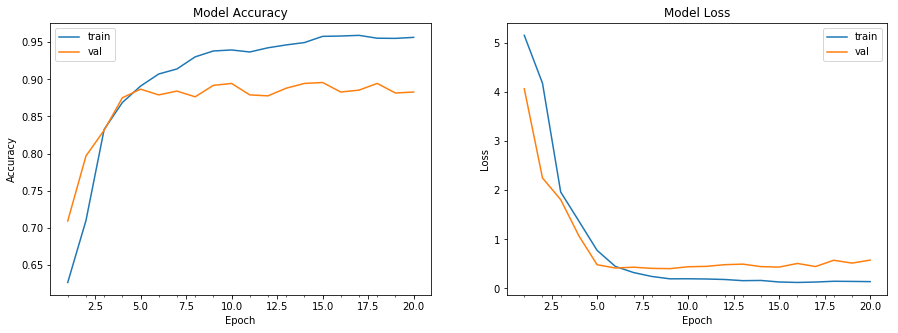

In [20]:
plot_model_history(model_info)

In [21]:
from sklearn.metrics import accuracy_score
result = model.predict(X_test)
accuracy_score(np.argmax(y_test, axis=1), np.argmax(result, axis=1))

# print('predicted', np.argmax(result, axis=1))
# print('actual', np.argmax(y_test, axis=1))

0.9202185792349726

In [22]:
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(result, axis=1))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = cm.round(2)
cm

array([[0.97, 0.01, 0.  , 0.01, 0.  , 0.01],
       [0.  , 0.97, 0.  , 0.01, 0.02, 0.  ],
       [0.01, 0.  , 0.9 , 0.01, 0.02, 0.07],
       [0.01, 0.  , 0.  , 0.85, 0.01, 0.13],
       [0.  , 0.09, 0.01, 0.  , 0.84, 0.07],
       [0.  , 0.02, 0.  , 0.01, 0.01, 0.96]])

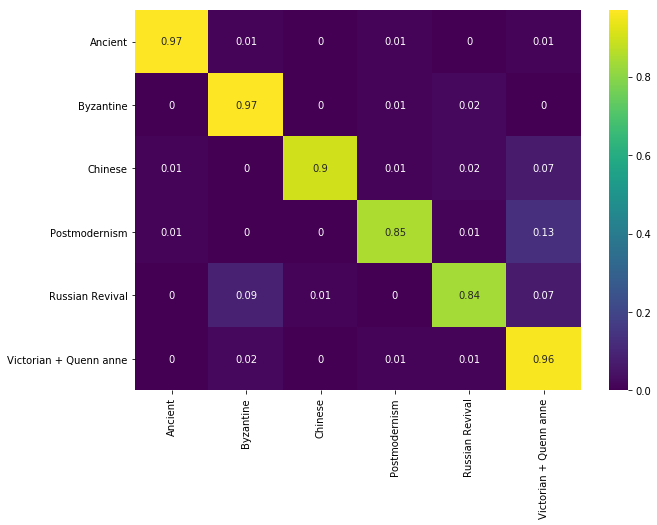

In [23]:

df_cm = pd.DataFrame(cm, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='viridis', fmt='g')